# Case txp

> In this case study, we are exploring deep learning interpretability on BSI prognosis, before, during and after training a CNN model on multi-variate time series medical record.
 
> we use hourly aggregated physiological data and lab results from 10,000 ICU patients. 1824 positive events and 31496 control group events are generated from the population. 

> we use 25 features selected by domain knowledge, 96 hours prior to the blood culture acquisition to classify positive test results from the control group -- negative test results and 4 days of randomly sliced baseline patient data.  


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

In [2]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd'

# initiate dataframe to return
all_df=None
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
print(bsi_stream.engineer.variable_dict)
print(bsi_stream.engineer.csv_source_dict)

Success: Querier has initiated a csv source dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.
{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id', 'oldid'], 'label': 'subject id', 'unique_per_sbj': True}, '__time': {'src_names': ['tsa', 'timeMinutes'], 'label': 'Time since admission', 'unit': 'minute'}, '__anchor': {'src_names': ['True_positive', 'True positive', 'label'], 'label': 'episode anchor', 'unique_per_sbj': False, 'shuffle': ['__nbc'], 'factor': {'levels': {'__nbc': ['nan'], '__ctm': ['contaminant'], '__neg': ['0', '0.0', 'negative'], '__pos': ['1', '1.0', 'true_positive']}, 'impute_per_sbj': {'nan_level': '__nbc'}}}, 'y': {'output': True, 'src_names': 

In [3]:
# bsi_stream.querier.create_csv_pool(csv_pool_dir = csv_pool_path,
#                                   source_key="uvanewbc",
#                                   file_key="all",
#                                   sep="_")

In [4]:
# bsi_stream.querier.create_csv_pool(csv_pool_dir = csv_pool_path,
#                                   source_key="uvanewnbc",
#                                   file_key="all",
#                                   sep="_")

In [5]:
## nbc (baseline) group 
# # define an episode (notice that the engineer now has new attributes)
# bsi_stream.engineer.DefineEpisode(input_time_len=1*60, # using vital signs and labs 4 days prior to a culture 
#                                   output_time_len=(4*24-1)*60, # predict one time unit into the future
#                                   time_resolution=60, # aggregate minutely data to one row per hour 
#                                   time_lag=0,  # no time lag between predictors and response
#                                   anchor_gap=4*24*60) # the minimum distance between two episodes

In [6]:
## nbc group 
bsi_stream.engineer.DefineEpisode(input_time_len=2*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=2*24*60, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

Success! Engineer has updated attributes --- episode. 


In [7]:
df_nbc = pd.read_csv("/Users/jiaxingqiu/Documents/CAMA_projects/BSI/2016_2021/data_ml/bsi_new_deidentified_nbc.csv")

In [13]:
len(list(df_nbc['id'].unique()))

23075

In [14]:
id_list = list(df_nbc['id'].unique())[10000:15000]
df_nbc_now = df_nbc.loc[df_nbc.id.isin(id_list),:]

In [15]:
df_nbc_now.shape

(601282, 66)

In [16]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 50, # number of subjects / patients to sample from the pool 
                              replace = False, # sample with replacement or not 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='none', # imputation on predictors
                              impute_output='none',# imputation on response (no need in BSI project)
                              sep="_", 
                              return_episode=True,
                              df_raw=df_nbc_now)


Engineer is sampling without replacement --- 
Just kidding :) Engineer is using external tabular data you input!
-- __time fixed
-- __anchor fixed
-- y fixed
--- fix upper boundary for age by 90.0
--- fix lower boundary for age by 18.03
-- age fixed
--- fix upper boundary for albumin by 4.9
--- fix lower boundary for albumin by 1.2
-- albumin fixed
--- fix upper boundary for alp by 1000.0
--- fix lower boundary for alp by 18.0
-- alp fixed
--- fix upper boundary for alt by 2500.0
--- fix lower boundary for alt by 6.0
-- alt fixed
--- fix upper boundary for ast by 2500.0
--- fix lower boundary for ast by 9.0
-- ast fixed
--- fix upper boundary for bicarbonate by 55.9
--- fix lower boundary for bicarbonate by 5.8
-- bicarbonate fixed
--- fix upper boundary for bun by 150.0
--- fix lower boundary for bun by 2.0
-- bun fixed
--- fix upper boundary for calcium by 13.89455
--- fix lower boundary for calcium by 5.2
-- calcium fixed
--- fix upper boundary for chloride by 137.0
--- fix lower bo

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5916453.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6966993.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7184712.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6695280.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5485170.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6527040.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5049591.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5177313.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6963276.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6242865.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6608010.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6463560.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5325885.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5437551.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6540189.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6576276.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6148671.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6187398.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6490191.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7037469.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5791656.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7036053.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5422128.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5323875.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5142162.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5416368.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5144598.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6275760.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5454687.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5080458.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6888402.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6434589.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6797250.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5081388.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6408327.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6810621.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5563842.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6054801.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6423501.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6032850.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5285742.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5217471.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5019066.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7228983.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7189467.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7379874.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6778128.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6955941.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6310065.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5170692.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6019542.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7114497.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5084355.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5834946.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6770106.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6753231.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5173368.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5693508.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5019177.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6493656.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5388075.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6945123.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6573885.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5793900.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6606318.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5121261.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6808095.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6920907.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6950013.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7053342.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6487380.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5907276.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5776998.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6073161.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5409747.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5771079.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5681106.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6642399.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6897624.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7108656.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5199249.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5391723.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4837710.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5825265.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6494700.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7314969.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5123955.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6073614.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6572382.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4883898.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5264949.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6872502.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6164199.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4892922.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5013597.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6352224.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5335170.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7187574.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5056125.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5840895.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4959642.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5615847.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6398580.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5984340.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6567456.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5044926.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7046925.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5132580.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5501391.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6668313.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5028312.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4946757.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6524199.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5017410.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6586572.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6103008.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6028575.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5229453.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6767625.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6218493.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6647259.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5686299.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5310936.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7289775.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7264965.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7339563.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5489739.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6327996.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6182352.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7125066.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6391428.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7304589.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6837036.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5650497.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5042847.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6859305.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5998662.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5352528.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6445320.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5274336.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7122726.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5577381.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6022350.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5235303.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5636277.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6043218.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7344507.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6782829.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5468235.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7260741.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4968351.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5507742.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5491926.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7296081.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5059155.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6459297.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5744877.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5615724.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5431500.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5502306.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5321577.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6809538.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6775647.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5087676.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6045234.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7070493.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7295835.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5613507.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5973453.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5334117.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4897332.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7371612.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5975244.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7155291.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6209637.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6355131.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6161496.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5020413.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5637576.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6563502.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7151082.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6929292.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6988410.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5896149.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7044657.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5455785.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5494842.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6531723.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7341543.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6077922.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7222743.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5101182.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4927812.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6633006.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6553470.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6747819.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6786447.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5532186.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6169704.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6248526.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6821295.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6444627.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5172480.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6365412.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5677665.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5742891.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6647937.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6827163.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7314489.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5521938.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5815194.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5824170.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6279702.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5034612.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4848258.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6454188.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4935660.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6488781.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6790764.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7277409.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5109522.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6140889.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6833745.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6065028.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5073039.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6414609.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5083491.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5599086.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5161041.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5683206.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5346684.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4911864.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7184274.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6792972.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7079586.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6322311.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6452442.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5133528.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6991608.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5385369.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4969317.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5773155.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6368142.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7232535.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5481648.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7198140.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6494898.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4892976.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4895490.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6353073.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7364451.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6632829.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5225340.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5105961.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6568290.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6583749.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6960951.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5819139.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5563698.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6474972.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5025378.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6188640.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6488586.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6752316.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4946880.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5369229.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5488230.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6165615.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5705514.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6575841.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6627591.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5889270.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5699193.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6318642.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7195383.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5738244.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6808794.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5829891.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6393459.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7187784.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6514350.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5160903.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5549481.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6676854.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7064505.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5324067.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5781798.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5333814.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6300834.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5277333.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4936542.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7077702.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5188050.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5144547.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5659983.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4920837.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5431263.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6618807.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6644052.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6246741.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5920827.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6076620.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6591831.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7173705.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5873415.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5900136.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6326991.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5548635.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4865055.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6017232.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4839672.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4969881.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5900199.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7298352.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6469569.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6512658.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7190934.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6992079.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5971758.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5088852.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6368211.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5421639.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5886165.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5237646.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5958498.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5493795.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6419172.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6350100.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6496140.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6995271.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5884035.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5887770.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7119747.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6960789.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6583287.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6050766.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6891639.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6169449.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5868684.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5738154.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6735594.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5317599.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7311195.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5001555.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4947594.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6572286.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5337810.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6435039.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6070056.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6699852.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6858579.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6233709.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6408402.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7309989.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5504832.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6086127.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5695173.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6929532.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4834827.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7319844.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6451863.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6751512.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7359336.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5587005.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7196781.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5710500.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6518823.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6154932.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5032662.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6962985.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6460320.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6326553.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5164140.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5190903.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5912820.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7157121.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5071110.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5259792.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5842638.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6134562.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5222691.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6470973.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5124216.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6167172.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5872902.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7053369.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4865070.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6681636.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6459147.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5012784.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5866956.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6106200.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6556026.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4868865.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6030228.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5117112.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7255305.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6494463.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5078385.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6307869.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5376765.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6389613.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7081128.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6039798.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5419071.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5599959.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5784030.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6666672.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6231543.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5257431.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6784161.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6005274.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6912879.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6913713.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5719407.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6755799.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6806460.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5554215.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7227081.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6492471.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5055837.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7352073.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6906024.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6889401.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5316666.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6863178.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7197750.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6027033.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6334764.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6307035.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6908598.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5161038.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6103185.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6379785.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5642439.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6095748.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5622585.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6461565.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5579484.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6771033.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5983149.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5501061.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5635383.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6421218.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5962119.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6699330.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5386437.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6953964.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4863846.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5015655.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6064068.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5680407.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6041439.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7160409.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5090106.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6039372.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6130395.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6878682.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6058089.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6857130.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6306573.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5907978.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7167804.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6766155.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5977074.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6282714.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6711366.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5412999.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6021726.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6386430.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7062954.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7270785.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6879909.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5765748.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5098911.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7262760.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5368296.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6840783.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6963711.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6439488.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4928844.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6812295.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7191471.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7229433.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6304920.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6879864.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5322975.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7256421.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7014405.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6917601.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6412878.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7324311.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6453651.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6387279.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6839682.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6657225.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5136438.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6841527.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6396759.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7346979.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4842939.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6120648.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6727542.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5587413.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6195729.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6961257.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4967664.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5415987.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7092051.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5022906.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6279813.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6550488.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6552009.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6451473.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6823977.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7302816.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6496083.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6473667.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6895392.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5868825.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6254907.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5746473.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5997660.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5715525.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6041946.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5609280.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5150637.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5558715.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7288401.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5617848.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5924373.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6520800.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5098545.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5599629.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6782643.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4879677.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6130305.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6487974.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6403653.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6436398.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5637537.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5682213.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6370941.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7058526.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7311930.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5366493.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5175594.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6397245.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6658143.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5269194.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6034779.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6233136.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5146824.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5417901.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6389205.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_4935672.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6611346.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7124133.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6820002.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5348721.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5852727.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7308780.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7019091.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7180776.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7094100.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6289674.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_7280175.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_5493678.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- prepare episodes for external_6334335.0
Success! Output/responce variable mean in current sample space  --- 
y___pos    0.0
y___nbc    1.0
y___ctm    0.0
y___neg    0.0
dtype: float64
--- shuffle [ __nbc ] episodes ---
Success! Engineer has updated attributes --- mvts_df, input_vars, out

In [17]:
all_df_new = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df_new = pd.concat( [all_df_new, bsi_stream.engineer.test_df], axis=0)
print(all_df_new.groupby(['txp___yes'])['__uid'].nunique())
if all_df is None:
    all_df = all_df_new
else:
    all_df = pd.concat( [all_df, all_df_new], axis=0)
print(len(set(all_df.__uid))) 

txp___yes
0.0    4743
1.0     257
Name: __uid, dtype: int64
8000


In [18]:
all_df.to_csv("./data_bsi_txp_4d_17_21_nbc_2.csv", index=False)

In [14]:
all_df = pd.read_csv("./data_bsi_txp_4d_17_21_nbc.csv")

In [16]:
all_df.to_csv("./data_bsi_txp_4d_17_21_nbc.csv", index=False)

<AxesSubplot:>

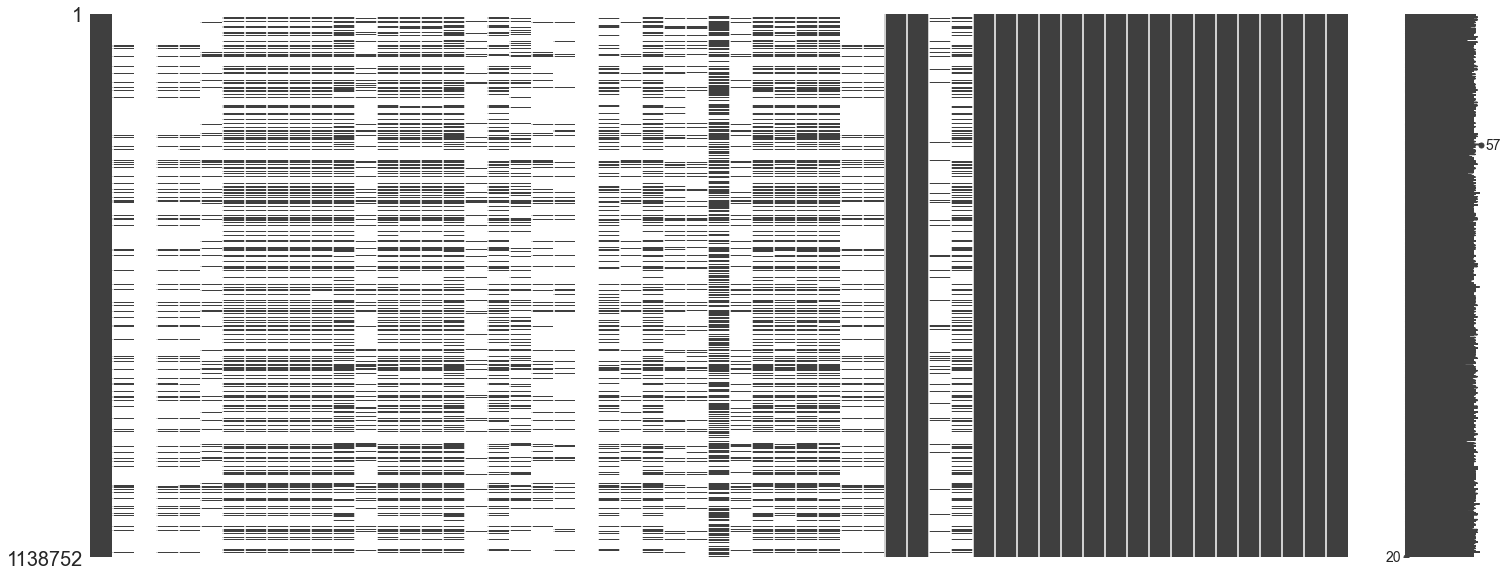

In [10]:
import missingno as msno
msno.matrix(all_df_new)

In [ ]:
bsi_stream.engineer.sbj_df.to_csv("./data_bsi_uva_old_sbj.csv",index=False)

In [ ]:
all_df_new = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df_new = pd.concat( [all_df_new, bsi_stream.engineer.test_df], axis=0)
import missingno as msno
#msno.matrix(all_df_new)

In [ ]:
# nbc
#all_df.to_csv("./data_bsi_txp_4d_nbc.csv",index=False)
# bc
#all_df.to_csv("./data_bsi_txp_4d_bc.csv",index=False)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

In [ ]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp'

In [ ]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

In [ ]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=2*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=24*60, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

In [ ]:
print(bsi_stream.engineer.episode)

In [ ]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 6000, # number of subjects / patients to sample from the pool 
                              replace=False, # sample with replacement or not 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median',
                              sep="_")# imputation on response (no need in BSI project)
# please see the end of console 
# --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

In [ ]:
all_df = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df = pd.concat( [all_df, bsi_stream.engineer.test_df], axis=0)
print(len(set(all_df.__uid)))
all_df.describe()

In [ ]:
from random import randint
import matplotlib.pylab as plt 
import numpy as np
from tensorflow.keras.models import Sequential, Model

def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,1,0))




def plot_features_map(input_image_list, 
                      cnn,
                      img_title_list,
                      layer_idx):
    
    nrow = len(layer_idx)
    ncol = len(input_image_list)
    
    fig, ax = plt.subplots(nrow+1, ncol, figsize=(20,20))
    
    for j in range(ncol):
        input_image = input_image_list[j]
        ax[0][j].imshow(input_image[:,:,0].transpose(1,0))
        ax[0][j].set_title(img_title_list[j])
        for i in range(nrow):
            feature_map = get_feature_maps(cnn, layer_idx[i], input_image)
            ax[i+1][j].imshow(feature_map[0,:,:])
            ax[i+1][j].set_title('layer {} - {}'.format(layer_idx[i], cnn.layers[layer_idx[i]].get_config()['name']))

    return

## setup

In [ ]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'


# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case4'

In [ ]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

## Define Episode

In [ ]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=4*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=1, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

## Build MVTS (multi-variable time series) data objects
- train_df_imputed, valid_df_imputed and test_df_imputed are dataframes
- train_tfds, valid_tfds and test_tfds are tensorflow datasets

In [ ]:
# # Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
# bsi_stream.engineer.BuildMVTS(csv_pool_path, 
#                               nsbj = 10, # number of subjects / patients to sample from the pool 
#                               valid_frac = 0.2, # fraction of number of subjects in validation dataset
#                               test_frac = 0.1, # fraction of number of subjects in left-out test dataset
#                               batch_size = 64, # batch size (usually 32,64,128..)
#                               impute_input='median', # imputation on predictors
#                               impute_output='median' )# imputation on response (no need in BSI project)

# # please see the end of console 
# # --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# # --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

### print all the attributes of the engineer

In [ ]:
# bsi_stream.engineer.info()

# # extract X, Y numpy array by engineer build-in function
# X_train, Y_train, X_valid, Y_valid, X_test, Y_test = bsi_stream.engineer.ExtractXY()

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_valid = X_valid.astype('float32')
# X_test = X_test.astype('float32')

# Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[2])
# Y_valid = Y_valid.reshape(Y_valid.shape[0], Y_valid.shape[2])
# Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[2])

# X_all = np.concatenate((X_train, X_valid, X_test), axis=0)
# Y_all = np.concatenate((Y_train, Y_valid, Y_test), axis=0)


In [ ]:
# specify input column names
bsi_stream.engineer.input_vars = ['age___vital', 'age___lab', 'temp___vital', 'heart_rate___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'resp_rate___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'wbc___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'paco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']


## --- Pre-modeling Interpretability (raw scale) ---

In [ ]:
X_all = np.load("./X_all.npy")
Y_all = np.load("./Y_all.npy")
X_train = np.load("./X_train.npy")
Y_train = np.load("./Y_train.npy")
X_valid = np.load("./X_valid.npy")
Y_valid = np.load("./Y_valid.npy")
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)

X_pos = X_all[Y_all[:,1]==1.0][:,:,:,0]
X_ctrl = X_all[Y_all[:,1]==0.0][:,:,:,0]
print("X_pos shape", X_pos.shape)
print("X_ctrl shape", X_ctrl.shape)


### 1. print a few episode as images

In [ ]:
fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10): 
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0,  # change zero to be not white 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_pos[i], cmap='bwr', norm=norm)
    axes[i].set_title('postive episode {}'.format(i))

fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10):
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_ctrl[i], cmap='bwr', norm=norm)
    axes[i].set_title('control episode {}'.format(i))

### 2. Visualize Statistical Moments -- Positive VS Control Group

#### Statistic Moment 1 -- mean

In [ ]:
# outlier in image

In [ ]:
X_pos_stat = X_pos.mean(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.mean(axis=0).transpose((1,0))
X_all_stat = X_all.mean(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()

im = ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[2])


#### Statistic Moment 2 -- std

In [ ]:
X_pos_stat = X_pos.std(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.std(axis=0).transpose((1,0))
X_all_stat = X_all.std(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])


#### Statistic Moment 3 -- skewness

In [ ]:
X_pos_stat = scipy.stats.skew(X_pos, axis=0).transpose((1,0))
X_ctrl_stat = scipy.stats.skew(X_ctrl, axis=0).transpose((1,0))
X_all_stat = scipy.stats.skew(X_all, axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

#### Statistic Moment 4 -- Kurtosis

In [ ]:
X_pos_stat = scipy.stats.kurtosis(X_pos, axis=0).transpose((1,0))
X_ctrl_stat = scipy.stats.kurtosis(X_ctrl, axis=0).transpose((1,0))
X_all_stat = scipy.stats.kurtosis(X_all, axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

## --- Modeling interpretation raw scale (CNN) ---

In [ ]:
X_train_2d = X_train[:,:,:,0].reshape(X_train[:,:,:,0].shape[0],-1)
X_valid_2d = X_valid[:,:,:,0].reshape(X_valid[:,:,:,0].shape[0],-1)
Y_train_binary = Y_train[:,1]
Y_valid_binary = Y_valid[:,1]
print(X_train_2d.shape)
print(Y_train_binary.shape)
print(X_valid_2d.shape)
print(Y_valid_binary.shape)

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear').fit(X_train_2d, Y_train_binary)

#to check the shape of the coefficient matrix
clf.coef_.shape

In [ ]:
scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 25));
nclasses=1
for i in range(nclasses):
    p = plt.subplot(1, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(96, 25).T,
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.axis('off')
    p = plt.title('positive');

### AUROC for logistic regression

In [ ]:
Y_valid_pred = clf.predict_proba(X_valid_2d)
sklearn.metrics.roc_auc_score(Y_valid_binary, Y_valid_pred[:,1])

### binary setup logistic regression

In [ ]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train.shape)[1:4]),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train_binary, 
              epochs=50, 
              validation_data=(X_valid,Y_valid_binary), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train_binary, 
              epochs=50, 
              validation_data=(X_valid,Y_valid_binary), callbacks=[callback])

### multiple classification setup logistic regression

In [ ]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
    #keras.metrics.recall(....),
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train.shape)[1:4]),
    keras.layers.Dense(2, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

In [ ]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
    keras.metrics.recall(....),
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Conv2D(64, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same',
                        input_shape=list(X_train.shape)[1:4]),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same'),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(1, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same'),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

In [ ]:
X_train_pos_img = X_train[Y_train[:,0]==1.0].mean(axis=0)
X_train_ctrl_img = X_train[Y_train[:,0]==0.0].mean(axis=0)

X_valid_pos_img = X_valid[Y_valid[:,0]==1.0].mean(axis=0)
X_valid_ctrl_img = X_valid[Y_valid[:,0]==0.0].mean(axis=0)

X_all_pos_img = X_all[Y_all[:,0]==1.0].mean(axis=0)
X_all_ctrl_img = X_all[Y_all[:,0]==0.0].mean(axis=0)

plot_features_map(input_image_list=[X_all_pos_img, X_all_ctrl_img,
                                    X_train_pos_img, X_train_ctrl_img, 
                                    X_valid_pos_img, X_valid_ctrl_img],
                  img_title_list=["POS (all)", "CTRL (all)",
                                  "POS (train)", "CTRL (train)", 
                                  "POS (valid)", " CTRL (valid)"],
                  layer_idx=[0,3,6], 
                  cnn=mdl)

## --- Post-Modeling interpretation (raw scale + saliency map) ---

In [ ]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
def plot_saliency(img_idx):
    grads = visualize_saliency(mdl,
                               "visualized_layer",
                               filter_indices=Y_all[img_idx][0], 
                               seed_input=X_all[img_idx], 
                               backprop_modifier=None,
                               grad_modifier="absolute")
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(X_all[img_idx])
    ax[0].set_title('original img id {}'.format(img_idx))
    ax[1].imshow(grads, cmap='jet')
    ax[1].set_title('saliency - predicted {}'.format(img_idx))

plot_saliency(img_idx = 0)

## --- Pre-training Interpretability (standardized) ---

In [ ]:
X_all = np.load("./X_all.npy")
Y_all = np.load("./Y_all.npy")
X_train = np.load("./X_train.npy")
Y_train = np.load("./Y_train.npy")
X_valid = np.load("./X_valid.npy")
Y_valid = np.load("./Y_valid.npy")
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)

X_train = (X_train - X_all.mean(axis=0))/X_all.std(axis=0)
X_valid = (X_valid - X_all.mean(axis=0))/X_all.std(axis=0)
X_all = (X_all - X_all.mean(axis=0))/X_all.std(axis=0)

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)


X_pos = X_all[Y_all[:,1]==1.0][:,:,:,0]
X_ctrl = X_all[Y_all[:,1]==0.0][:,:,:,0]
print("X_pos shape", X_pos.shape)
print("X_ctrl shape", X_ctrl.shape)


In [ ]:
fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10): 
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_pos[i], cmap='bwr', norm=norm)
    axes[i].set_title('postive episode {}'.format(i))

fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10):
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_ctrl[i], cmap='bwr', norm=norm)
    axes[i].set_title('control episode {}'.format(i))

#### Statistic Moment 1 -- mean

In [ ]:
X_pos_stat = X_pos.mean(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.mean(axis=0).transpose((1,0))
X_all_stat = X_all.mean(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()

im = ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[2])


### Statistic Moment 2 -- std

In [ ]:
X_pos_stat = X_pos.std(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.std(axis=0).transpose((1,0))
X_all_stat = X_all.std(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

#### Statistic Moment 3 -- skewness

#### Statistic Moment 4 -- Kurtosis